# Classical AB Testing

In [1]:
#Importing Libraries
import sys
import os
import dvc.api
import numpy as np
import scipy.stats as stats 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Defining our Experiment

Ho(null hypothesis): users who saw the smart Ad(treated users) don't show any difference
                    in responding to the Bio to the ones who were shown the dummy Ad 
H1(Alternative hypothesis): exposed users are more responsive to the BIO than the ones shown the dummy Ad


#to see which of the group respond better we have to use the two tailed test
    #let P0 is conversion rate of the controled users and
    #let p is conversion rate of the exposed users
#so for Ho- p0=p
        H1- p0<p
               
and defining a confidence level of 95%,the acceptable value of type I error α= (1-0.95)=0.05
                
    setting statistical power to 80%, so beta B(Beta) = 0.2 or 20%
    

In [14]:
#getting clean data from output of data exploration
df= pd.read_csv('../data/AdSmartABdata.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


# Identifing Conversion Rates

In [16]:
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../Scripts/')

In [17]:
from classic_ab import classics
from Graphs import draw

In [18]:
cleaned_df = df[['auction_id', 'experiment', 'yes', 'no']]
not_ans_df = cleaned_df.query("yes == 0 & no == 0")
not_ans_df

,auction_id,experiment,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,0,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,0,0
5,0027ce48-d3c6-4935-bb12-dfb5d5627857,control,0,0
...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,0,0


In [19]:
print(f"The number of users that did not respond is {not_ans_df.shape[0]} ")
print(f"The percentage of users that did not respond is {(not_ans_df.shape[0] / df.shape[0]) * 100:0.2f}% ")

The number of users that did not respond is 6834 
The percentage of users that did not respond is 84.61% 


##### we have almost 85 percent of the data with non response rate which is a blocker around the conclusion

In [20]:
cleaned_df = cleaned_df.query("not (yes == 0 & no == 0)")
cleaned_df.groupby("experiment").agg({"yes": "sum", "no":"sum"})

cleaned_df_agg = cleaned_df.groupby("experiment").agg({"yes": "sum", "no":"sum"})
cleaned_df_agg['aware'] = [0,0]
cleaned_df_agg['aware']['control'] = cleaned_df_agg['yes']['control']
cleaned_df_agg['aware']['exposed'] = cleaned_df_agg['yes']['exposed']

cleaned_df_agg['total'] = [0, 0]
cleaned_df_agg['total']['control'] = cleaned_df_agg['yes']['control'] +  cleaned_df_agg['no']['control']
cleaned_df_agg['total']['exposed'] = cleaned_df_agg['yes']['exposed'] + cleaned_df_agg['no']['exposed']

print(f"number of pepole that are aware of the brand lux in control group are: {cleaned_df_agg['aware']['control']}")
print(f"number of pepole that are aware of the brand lux in exposed group are: {cleaned_df_agg['aware']['exposed']}")

test_df = cleaned_df_agg.copy()
test_df

number of pepole that are aware of the brand lux in control group are: 264
number of pepole that are aware of the brand lux in exposed group are: 308


,yes,no,aware,total
experiment,,,,
control,264,322,264,586
exposed,308,349,308,657


# Conversion rate for both experiment group

### Control

In [21]:
control_conversion_rate = test_df['aware']['control'] / test_df['total']['control']
print(f" The conversion rate of control group is {control_conversion_rate:0.2f}")

 The conversion rate of control group is 0.45


### Exposed

In [22]:
exposed_conversion_rate = test_df['aware']['exposed'] / test_df['total']['exposed']
print(f" The conversion rate of exposed group is {exposed_conversion_rate:0.2f}")

 The conversion rate of exposed group is 0.47


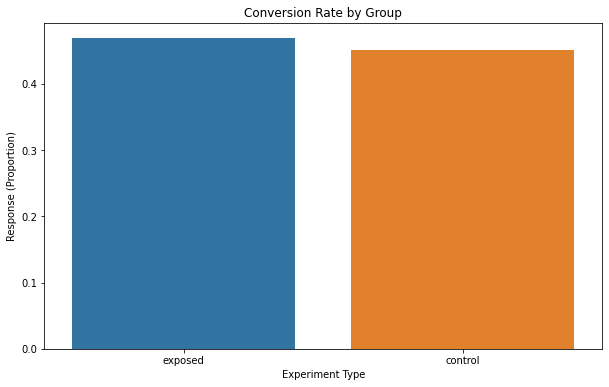

In [66]:
#plotting controlled and exposed agasist response
draw.modified_bar_plot(combined_df, 'experiment', 'response','Conversion Rate by Group')

### not so much difference in the conversion rate

In [23]:
#calculating the varance of control and exposed rate
diff = exposed_conversion_rate - control_conversion_rate

variance_contorl = control_conversion_rate * (1 - control_conversion_rate)
variance_exposed = exposed_conversion_rate * (1 - exposed_conversion_rate)

In [27]:
#calculating the standard error for control group(which describe how much a std deviation of a sample represent the poulation)
contorl_total = cleaned_df_agg['total']['control']
standar_err_control = np.sqrt(variance_contorl)/np.sqrt(contorl_total)

standar_err_control

0.02055339057798332

In [26]:
#calculating the standard error for control group
exposed_total = cleaned_df_agg['total']['exposed']
standar_err_exposed = np.sqrt(variance_exposed)/np.sqrt(exposed_total)

standar_err_exposed

0.019468837373132736

###### Std error is small for both groups which means that, sample means are closely distributed around the population mean so your sample is representative of your population

# Calculating Shift Awareness

In [29]:
#shift in awareness betweeen the two groups to see the effect of the smart Ad
import scipy.stats as scs
shift  = (exposed_conversion_rate - control_conversion_rate) / control_conversion_rate

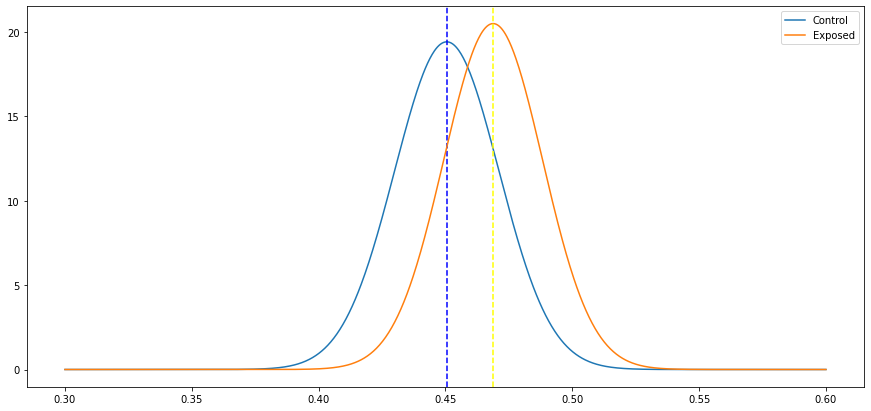

In [36]:
fig, ax = plt.subplots(figsize=(15,7))

x = np.linspace(0.3, 0.6, 1000)

ctr_rate_prob = scs.norm(control_conversion_rate, standar_err_control).pdf(x)
ax.plot(x, ctr_rate_prob, label='Control')
ax.axvline(x=control_conversion_rate, c='blue', linestyle='--')



exposed_rate_prob = scs.norm(exposed_conversion_rate, standar_err_exposed).pdf(x)
ax.plot(x, exposed_rate_prob, label='Exposed')
ax.axvline(x=exposed_conversion_rate, c='yellow', linestyle='--')
plt.legend()

In [31]:
print(f"The awareness of the exposed group has been increased by {shift * 100:0.2f}%" )

The awareness of the exposed group has been increased by 4.06%


# Testing the Hypothesis

In [41]:
## as seen from the graph above showing the smart Ad to the treatment havent bring that much change in awareness of the lux brand
#defining both exposed groups
def is_significant(A_rate, B_rate, A_total, B_total, alpha=0.05, tail="one"):
    diff = B_rate - A_rate
    
    A_variance =  A_rate * (1 - A_rate)
    B_variance  = B_rate * (1 - B_rate)
    
    z_score = diff / np.sqrt((A_variance/A_total) + (B_variance/B_total))

    p_value  = scs.norm().sf(z_score)
    
    if (tail == "one"):
        compare = alpha
    else:
        comapre = alpha / 2   #for two tailed test we distribute the alpha to the two sides
        
    return abs(p_value) < alpha, p_value, z_score
        

In [42]:
alpha = 0.05

is_signi, p_value, z_score = is_significant(control_conversion_rate, exposed_conversion_rate,
                                            contorl_total, exposed_total, alpha=alpha)


z_score = diff / np.sqrt((variance_contorl/contorl_total) + (variance_exposed/exposed_total))
print (f"the calculated z score is {z_score:0.2f}" )

p_value  = scs.norm().sf(z_score)
print (f"the calculated p value is {p_value:0.2f}" )

is_signi, p_value, z_score = is_significant(control_conversion_rate, exposed_conversion_rate,
                                            contorl_total, exposed_total)

print(f"Is the value significant: {is_signi}")

the calculated z score is 0.65
the calculated p value is 0.26
Is the value significant: False


### Interpretation

1- The **z-Score** indicates by how much standard deviation does a given data point vary from its mean so given a 0.65.
2- The **P-value** i.e.e 0.26 is greater than the threshold value(0.05) which implies that it's not statistically siginificant and to retain null hypothesis and Reject the Alternantive hypothesis(H1) set in the notebook above

**N.B** But we cant exactly say we are accepting the null hypotheis but we say that we failed to reject the null hypothesis   since there is still a room of for not fully accepting the null hypothesis i.e. alpha=0.05 